In [1]:
import numpy as np
from astropy.io import fits
import healpy as hp
import pandas as pd
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
import pickle


### Retrieving the relevant CCD Data

In [2]:

decamCCD = fits.open('../bricks_data/ccds-annotated-decam-dr9.fits')
mosaicCCD = fits.open('../bricks_data/ccds-annotated-mosaic-dr9.fits')
bassCCD = fits.open('../bricks_data/ccds-annotated-90prime-dr9.fits')
print(decamCCD[1].columns)


ColDefs(
    name = 'image_filename'; format = '120A'
    name = 'image_hdu'; format = 'I'
    name = 'camera'; format = '5A'
    name = 'expnum'; format = 'K'
    name = 'plver'; format = '8A'
    name = 'procdate'; format = '19A'
    name = 'plprocid'; format = '7A'
    name = 'ccdname'; format = '3A'
    name = 'object'; format = '35A'
    name = 'propid'; format = '10A'
    name = 'filter'; format = '1A'
    name = 'exptime'; format = 'E'
    name = 'mjd_obs'; format = 'D'
    name = 'airmass'; format = 'E'
    name = 'fwhm'; format = 'E'
    name = 'width'; format = 'I'
    name = 'height'; format = 'I'
    name = 'ra_bore'; format = 'D'
    name = 'dec_bore'; format = 'D'
    name = 'crpix1'; format = 'E'
    name = 'crpix2'; format = 'E'
    name = 'crval1'; format = 'D'
    name = 'crval2'; format = 'D'
    name = 'cd1_1'; format = 'E'
    name = 'cd1_2'; format = 'E'
    name = 'cd2_1'; format = 'E'
    name = 'cd2_2'; format = 'E'
    name = 'yshift'; format = 'L'
    name = 

In [3]:
dataDecam = decamCCD[1].data
dataMosaic = mosaicCCD[1].data
dataBass = bassCCD[1].data

In [4]:
# Extracting Corners Only needed for visualisation

ra0 = np.concatenate((dataDecam.field('ra0'), dataMosaic.field('ra0'), dataBass.field('ra0')), axis=0)
dec0 = np.concatenate((dataDecam.field('dec0'), dataMosaic.field('dec0'), dataBass.field('dec0')), axis=0)

ra1 = np.concatenate((dataDecam.field('ra1'), dataMosaic.field('ra1'), dataBass.field('ra1')), axis=0)
dec1 = np.concatenate((dataDecam.field('dec1'), dataMosaic.field('dec1'), dataBass.field('dec1')), axis=0)

ra2 = np.concatenate((dataDecam.field('ra2'), dataMosaic.field('ra2'), dataBass.field('ra2')), axis=0)
dec2 = np.concatenate((dataDecam.field('dec2'), dataMosaic.field('dec2'), dataBass.field('dec2')), axis=0)

ra3 = np.concatenate((dataDecam.field('ra3'), dataMosaic.field('ra3'), dataBass.field('ra3')), axis=0)
dec3 = np.concatenate((dataDecam.field('dec3'), dataMosaic.field('dec3'), dataBass.field('dec3')), axis=0)

#Extracting systematics
filter_colour = np.concatenate((dataDecam.field('filter'), dataMosaic.field('filter'), dataBass.field('filter')), axis=0)

#camera = np.concatenate((dataDecam.field('camera'), dataMosaic.field('camera'), dataBass.field('camera')), axis=0)


exptime = np.concatenate((dataDecam.field('exptime'), dataMosaic.field('exptime'), dataBass.field('exptime')), axis=0)
airmass = np.concatenate((dataDecam.field('airmass'), dataMosaic.field('airmass'), dataBass.field('airmass')), axis=0)
fwhm = np.concatenate((dataDecam.field('fwhm'), dataMosaic.field('fwhm'), dataBass.field('fwhm')), axis=0)
#skyrms = np.concatenate((dataDecam.field('skyrms'), dataMosaic.field('skyrms'), dataBass.field('skyrms')), axis=0)

#sig1 = np.concatenate((dataDecam.field('sig1'), dataMosaic.field('sig1'), dataBass.field('sig1')), axis = 0)
#ccdskycounts = np.concatenate((dataDecam.field('ccdskycounts'), dataMosaic.field('ccdskycounts'), dataBass.field('ccdskycounts')), axis = 0)

ccdskysb = np.concatenate((dataDecam.field('ccdskysb'), dataMosaic.field('ccdskysb'), dataBass.field('ccdskysb')), axis = 0)
                          
                          
#ccdphrms = np.concatenate((dataDecam.field('ccdphrms'), dataMosaic.field('ccdphrms'), dataBass.field('ccdphrms')), axis = 0)
                          
                          
#phrms = np.concatenate((dataDecam.field('phrms'), dataMosaic.field('phrms'), dataBass.field('phrms')), axis = 0)
                       
                       
#ccdnastrom = np.concatenate((dataDecam.field('ccdnastrom'), dataMosaic.field('ccdnastrom'), dataBass.field('ccdnastrom')), axis = 0)
                            
                            
ccdnphotom = np.concatenate((dataDecam.field('ccdnphotom'), dataMosaic.field('ccdnphotom'), dataBass.field('ccdnphotom')), axis = 0)
                            
                            
meansky = np.concatenate((dataDecam.field('meansky'), dataMosaic.field('meansky'), dataBass.field('meansky')), axis = 0)
                         
                         
                         
#stdsky = np.concatenate((dataDecam.field('stdsky'), dataMosaic.field('stdsky'), dataBass.field('stdsky')), axis = 0)
                        
                        
#maxsky = np.concatenate((dataDecam.field('maxsky'), dataMosaic.field('maxsky'), dataBass.field('maxsky')), axis = 0)
                        
                        
#minsky = np.concatenate((dataDecam.field('minsky'), dataMosaic.field('minsky'), dataBass.field('minsky')), axis = 0)
                        
                        
#pixscale_mean = np.concatenate((dataDecam.field('pixscale_mean'), dataMosaic.field('pixscale_mean'), dataBass.field('pixscale_mean')), axis = 0)
                               
                               
#pixscale_std = np.concatenate((dataDecam.field('pixscale_std'), dataMosaic.field('pixscale_std'), dataBass.field('pixscale_std')), axis = 0)
                              
                              
                              
#pixscale_max = np.concatenate((dataDecam.field('pixscale_max'), dataMosaic.field('pixscale_max'), dataBass.field('pixscale_max')), axis = 0)
                              
                              
                              
#pixscale_min = np.concatenate((dataDecam.field('pixscale_min'), dataMosaic.field('pixscale_min'), dataBass.field('pixscale_min')), axis = 0)
                              
                              
#galnorm_mean = np.concatenate((dataDecam.field('galnorm_mean'), dataMosaic.field('galnorm_mean'), dataBass.field('galnorm_mean')), axis = 0)
                              
                              
                              
#galnorm_std = np.concatenate((dataDecam.field('galnorm_std'), dataMosaic.field('galnorm_std'), dataBass.field('galnorm_std')), axis = 0)
                             
                             
                             
#humidity = np.concatenate((dataDecam.field('humidity'), dataMosaic.field('humidity'), dataBass.field('humidity')), axis = 0)
                          
                          
#outtemp = np.concatenate((dataDecam.field('outtemp'), dataMosaic.field('outtemp'), dataBass.field('outtemp')), axis = 0)
                         
                         
#tileebv = np.concatenate((dataDecam.field('tileebv'), dataMosaic.field('tileebv'), dataBass.field('tileebv')), axis = 0)
                         
                         
                         
ebv = np.concatenate((dataDecam.field('ebv'), dataMosaic.field('ebv'), dataBass.field('ebv')), axis = 0)
                     
                     
galdepth = np.concatenate((dataDecam.field('galdepth'), dataMosaic.field('galdepth'), dataBass.field('galdepth')), axis = 0)
                          
                          
#gaussgaldepth = np.concatenate((dataDecam.field('gaussgaldepth'), dataMosaic.field('gaussgaldepth'), dataBass.field('gaussgaldepth')), axis = 0)
                               
                               
                               

In [5]:
df = pd.read_csv('../bricks_data/galaxy_catalogue_sample.csv')

ra = df["RA"].to_numpy(copy=True)
dec = df["DEC"].to_numpy(copy=True)

raDec = np.stack((ra,dec), axis=1)

print(raDec.shape)

def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))

NSIDE = 256
NPIX = hp.nside2npix(NSIDE)


(379416, 2)


### Now, trying to actually get all ccds per pixel
Begin by loading the Dictionary mapping pixels to CCDs. Afterwards, iterating through the ccds for a given pixel.
Depending on the systematics, we have to break systematics down into the different bands.
Airmass is simply averaged across all CCDs, exposure times are calculated on a per CCD basis.


In [6]:
with open('../bricks_data/pixel2ccd_256.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

Number of CCDs in the given pixel:  57


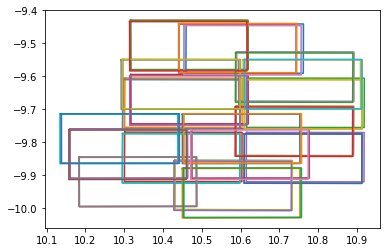

In [7]:
sample_pixel = 459294

# Plot what a given pixel looks like in terms of CCDs

ccds_per_pixel = pixel2ccd_dict[sample_pixel]

print("Number of CCDs in the given pixel: ", len(ccds_per_pixel))
for ccd in ccds_per_pixel:
    #coord = [[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]
        xs = [ra0[ccd],ra1[ccd], ra2[ccd], ra3[ccd],ra0[ccd] ]
        ys = [dec0[ccd],dec1[ccd], dec2[ccd], dec3[ccd],dec0[ccd]]
        plt.plot(xs,ys)


#### Classifying whether a given galaxy is inside one of the CCDs in a pixel

In [8]:
# Identifying which CCD features a given Galaxy
# Looping through CCDs



ccds_per_pixel = pixel2ccd_dict[sample_pixel]

# getting a subset of only those galaxies that are within a given pixel:

theta, phi = raDec2thetaPhi(ra, dec)
pixel_indices = hp.ang2pix(NSIDE, theta,phi)

galaxies_in_sample_pixel = (pixel_indices == sample_pixel)
ra_sample_pixel = ra[galaxies_in_sample_pixel]
dec_sample_pixel = dec[galaxies_in_sample_pixel]
raDec_sample_pixel = np.stack((ra_sample_pixel,dec_sample_pixel), axis=1)

print(len(ra_sample_pixel))
print(len(dec_sample_pixel))

453
453


Number of CCDs per pixel: 57
Number of Objects per pixel: 453


<ipython-input-9-5c1809221d22>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pixel_boundary = hp.boundaries(nside=NSIDE, pix=sample_pixel, step=1)
<ipython-input-9-5c1809221d22>:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

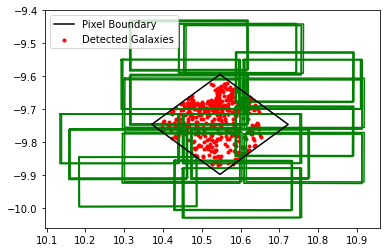

In [9]:
print("Number of CCDs per pixel:", len(ccds_per_pixel))
print("Number of Objects per pixel:", len(ra_sample_pixel))
'''
for ccd in ccds_per_pixel:
    #coord = [[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]
        xs = [ra0[ccd],ra1[ccd], ra2[ccd], ra3[ccd],ra0[ccd] ]
        ys = [dec0[ccd],dec1[ccd], dec2[ccd], dec3[ccd],dec0[ccd]]
        plt.plot(xs,ys, c='green', label="CCD Boundaries")
'''
xs = [ra0[ccds_per_pixel],ra1[ccds_per_pixel], ra2[ccds_per_pixel], ra3[ccds_per_pixel],ra0[ccds_per_pixel] ]
ys = [dec0[ccds_per_pixel],dec1[ccds_per_pixel], dec2[ccds_per_pixel], dec3[ccds_per_pixel],dec0[ccds_per_pixel]]
plt.plot(xs,ys, c='green')

pixel_boundary = hp.boundaries(nside=NSIDE, pix=sample_pixel, step=1)
pixel_boundary_raDec = hp.vec2ang(pixel_boundary.transpose(),lonlat=True)
pixel_boundary_raDec = list(pixel_boundary_raDec)
pixel_boundary_raDec[0] = np.append(pixel_boundary_raDec[0],pixel_boundary_raDec[0][0])
pixel_boundary_raDec[1] = np.append(pixel_boundary_raDec[1],pixel_boundary_raDec[1][0])


plt.plot(pixel_boundary_raDec[0],pixel_boundary_raDec[1], c='black', label="Pixel Boundary")


plt.scatter(ra_sample_pixel, dec_sample_pixel, c='red', marker='.', label="Detected Galaxies")

plt.legend()
plt.show()
# Note: The cluster in the middle is the result that there are limited bricks used so far: 453 objects only in this pixel

453
57


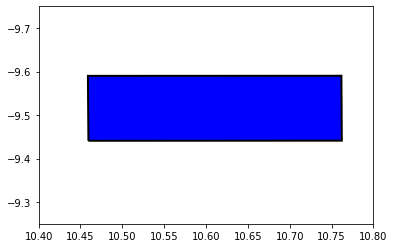

Airmass in pixel 459294 : 0.0


In [47]:
import matplotlib.patches as patches
airmass_value_aggr = 0.0
objects_per_pixel = len(raDec_sample_pixel)
print(objects_per_pixel)
print(len(ccds_per_pixel))

#Loop through all objects/galaxies in the pixel:
for galaxy in range(objects_per_pixel):
    airmass_galaxy = 0.0
    ccd_per_galaxy = 0
# For all CCDs in a pixel, we check whether the given galaxy is in them
    for no in ccds_per_pixel:
        c+=1
        #for no in ccds_per_pixel:
        x0 = ra0[no]
        x1 = ra1[no]
        x2 = ra2[no]
        x3 = ra3[no]

        y0 = dec0[no]
        y1 = dec1[no]
        y2 = dec2[no]
        y3 = dec3[no]

        #Define a Bounding Box Polygon using the coorners of a CCD
        boundingBoxPath = mplPath.Path(np.array([[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]))
        
        #Code to identify whether a polygon drawn for a given CCD is actually a rectangle
        #print(type(boundingBoxPath))
        
        
        fig, ax = plt.subplots()
        patch = patches.PathPatch(boundingBoxPath, facecolor='blue', lw=2)
        ax.add_patch(patch)
        ax.set_xlim(10.4,10.8)
        ax.set_ylim(-9.25,-9.75)
        plt.show()
        break
        
        #If the object is in the pixel, add the airmass for this ccd to the pixel value
        #Some of these are zero since there are not yet complete galaxy surveys
        if boundingBoxPath.contains_point(raDec_sample_pixel[galaxy]):
            airmass_galaxy += airmass[no]
            ccd_per_galaxy += 1
    break
    # Add the average airmass for this galaxy to the airmass for the pixel
    airmass_value_aggr += airmass_galaxy/ccd_per_galaxy
    #print(airmass_value_aggr)

# Get the mean airmass across all objects in the pixel
airmass_pixel = airmass_value_aggr/objects_per_pixel
print("Airmass in pixel", sample_pixel, ":", airmass_pixel)


### Looping through the entire catalogue 

In [10]:
pixels = pixel2ccd_dict.keys()

print(len(pixels))

455672


In [19]:
theta, phi = raDec2thetaPhi(ra, dec)
pixel_indices = hp.ang2pix(NSIDE, theta,phi)
pixel2systematics_dict = {}


for i,sample_pixel in enumerate(pixels):
    
    ccds_per_pixel = pixel2ccd_dict[sample_pixel]

    # getting a subset of only those galaxies that are within a given pixel:
    galaxies_in_sample_pixel = (pixel_indices == sample_pixel)
    objects_per_pixel = galaxies_in_sample_pixel.sum()
    # For the moment, only focusing on those pixels in the corpus where I have more than 100 galaxies already
    if objects_per_pixel < 100:
        continue
    ra_sample_pixel = ra[galaxies_in_sample_pixel]
    dec_sample_pixel = dec[galaxies_in_sample_pixel]
    raDec_sample_pixel = np.stack((ra_sample_pixel,dec_sample_pixel), axis=1)

        
    airmass_aggregate = 0
    fwhm_aggregate = 0
    ebv_aggregate = 0
    ccdnphotom_aggregate = 0
    
    ccdskysb_aggregate_g = 0
    ccdskysb_aggregate_r = 0
    ccdskysb_aggregate_z = 0
    
    exptime_aggregate_g = 0
    exptime_aggregate_r = 0
    exptime_aggregate_z = 0

    meansky_aggregate_g = 0
    meansky_aggregate_r = 0
    meansky_aggregate_z = 0
    
    galdepth_aggregate_g = 0
    galdepth_aggregate_r = 0
    galdepth_aggregate_z = 0
    
    
    #Loop through all objects/galaxies in the pixel:
    for galaxy in range(objects_per_pixel):
        airmass_galaxy = 0.0
        fwhm_galaxy = 0.0
        ebv_galaxy = 0.0
        ccdnphotom_galaxy = 0.0
        
        ccdskysb_galaxy_g = 0.0
        ccdskysb_galaxy_r = 0.0
        ccdskysb_galaxy_z = 0.0
        exptime_galaxy_g = 0.0
        exptime_galaxy_r = 0.0
        exptime_galaxy_z = 0.0
        meansky_galaxy_g = 0.0
        meansky_galaxy_r = 0.0
        meansky_galaxy_z = 0.0
        galdepth_galaxy_g = 0.0
        galdepth_galaxy_r = 0.0
        galdepth_galaxy_z = 0.0
    
    
        ccd_per_galaxy = 0
        ccd_per_galaxy_g = 0
        ccd_per_galaxy_r = 0
        ccd_per_galaxy_z = 0
            
            
    # For all CCDs in a pixel, we check whether the given galaxy is in them
        for no in ccds_per_pixel:
            #for no in ccds_per_pixel:
            x0 = ra0[no]
            x1 = ra1[no]
            x2 = ra2[no]
            x3 = ra3[no]

            y0 = dec0[no]
            y1 = dec1[no]
            y2 = dec2[no]
            y3 = dec3[no]

            #Define a Bounding Box Polygon using the coorners of a CCD
            boundingBoxPath = mplPath.Path(np.array([[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]))

            #If the object is in the pixel, add the airmass for this ccd to the pixel value
            #Some of these are zero since there are not yet complete galaxy surveys
            if boundingBoxPath.contains_point(raDec_sample_pixel[galaxy]):
                airmass_galaxy += airmass[no]
                fwhm_galaxy += fwhm[no]
                ebv_galaxy += ebv[no]
                ccdnphotom_galaxy += ccdnphotom[no]
                ccd_per_galaxy += 1
                
                if filter_colour[no] == 'g':
                    ccdskysb_galaxy_g += ccdskysb[no]
                    exptime_galaxy_g += exptime[no]
                    meansky_galaxy_g += meansky[no]
                    galdepth_galaxy_g += galdepth[no]
                    ccd_per_galaxy_g += 1

                if filter_colour[no] == 'r':
                    ccdskysb_galaxy_r += ccdskysb[no]
                    exptime_galaxy_r += exptime[no]
                    meansky_galaxy_r += meansky[no]
                    galdepth_galaxy_r += galdepth[no]
                    ccd_per_galaxy_r += 1 
                
                if filter_colour[no] == 'z':
                    ccdskysb_galaxy_z += ccdskysb[no]
                    exptime_galaxy_z += exptime[no]
                    meansky_galaxy_z += meansky[no]
                    galdepth_galaxy_z += galdepth[no]
                    ccd_per_galaxy_z += 1

        # Add the average airmass for this galaxy to the airmass for the pixel
        if ccd_per_galaxy > 0:
            airmass_aggregate += airmass_galaxy/ccd_per_galaxy
            fwhm_aggregate += fwhm_galaxy/ccd_per_galaxy
            ebv_aggregate += ebv_galaxy/ccd_per_galaxy
            ccdnphotom_aggregate += ccdnphotom_galaxy/ccd_per_galaxy

        if ccd_per_galaxy_g > 0: 
            ccdskysb_aggregate_g += ccdskysb_galaxy_g/ccd_per_galaxy_g
            exptime_aggregate_g += exptime_galaxy_g/ccd_per_galaxy_g
            meansky_aggregate_g += meansky_galaxy_g/ccd_per_galaxy_g
            galdepth_aggregate_g += galdepth_galaxy_g/ccd_per_galaxy_g
            
        if ccd_per_galaxy_r > 0: 
            ccdskysb_aggregate_r += ccdskysb_galaxy_r/ccd_per_galaxy_r
            exptime_aggregate_r += exptime_galaxy_r/ccd_per_galaxy_r
            meansky_aggregate_r += meansky_galaxy_r/ccd_per_galaxy_r
            galdepth_aggregate_r += galdepth_galaxy_r/ccd_per_galaxy_r
            
        if ccd_per_galaxy_z > 0: 
            ccdskysb_aggregate_z += ccdskysb_galaxy_z/ccd_per_galaxy_z
            exptime_aggregate_z += exptime_galaxy_z/ccd_per_galaxy_z
            meansky_aggregate_z += meansky_galaxy_z/ccd_per_galaxy_z
            galdepth_aggregate_z += galdepth_galaxy_z/ccd_per_galaxy_z
        # End LOOP
    
    # Average Across the Pixel
    systematics_per_pixel = []
    systematics_per_pixel.append(airmass_aggregate/objects_per_pixel)
    systematics_per_pixel.append(fwhm_aggregate/objects_per_pixel)
    systematics_per_pixel.append(ebv_aggregate/objects_per_pixel)
    systematics_per_pixel.append(ccdnphotom_aggregate/objects_per_pixel)
    
    systematics_per_pixel.append(ccdskysb_aggregate_g/objects_per_pixel)
    systematics_per_pixel.append(ccdskysb_aggregate_r/objects_per_pixel)
    systematics_per_pixel.append(ccdskysb_aggregate_z/objects_per_pixel)
    
    systematics_per_pixel.append(exptime_aggregate_g/objects_per_pixel)
    systematics_per_pixel.append(exptime_aggregate_r/objects_per_pixel)
    systematics_per_pixel.append(exptime_aggregate_z/objects_per_pixel)

    systematics_per_pixel.append(meansky_aggregate_g/objects_per_pixel)
    systematics_per_pixel.append(meansky_aggregate_r/objects_per_pixel)
    systematics_per_pixel.append(meansky_aggregate_z/objects_per_pixel)
                                 
    systematics_per_pixel.append(galdepth_aggregate_g/objects_per_pixel)
    systematics_per_pixel.append(galdepth_aggregate_r/objects_per_pixel)
    systematics_per_pixel.append(galdepth_aggregate_z/objects_per_pixel)
    
    pixel2systematics_dict[sample_pixel] = systematics_per_pixel    
    # Get the mean airmass across all objects in the pixel
                              
    if i % 4567 == 0:
        print(i/4567, '%')

print(len(pixel2systematics_dict.keys()))
#Sshould be 1548

1567


In [20]:
with open(f'../bricks_data/pixel2systematics_kitanidis.pickle', 'wb') as f:
    pickle.dump(pixel2systematics_dict, f)
    f.close()

In [ ]:
gi